# Ablation Study: Initialization Burn-In Period
Here we perform an ablation study demonstrating the (potential) benefit in using an initialization burn-in period (IBP) for PATT by running two versions of PATT-GPSS (with IBP and without IBP) for the Gaussian target $\nu = \mathcal{N}_d(\tau, \Pi)$, where $\tau = (d,0,...,0)^T \in \mathbb{R}^d$ and
$$ \Pi_{i,j} = \begin{cases} 1 & i = j , \\ 0.75 & i \neq j , \end{cases} $$
in dimension $d = 100$.

In [1]:
from patt_mcmc import patt_gpss
import mcmc_utils as mcu
import plotting_functions as pfs

In [2]:
import numpy as np
import numpy.linalg as alg
import numpy.random as rnd
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
path_prefix = "../plots/ablation_study_init_burn-in_"

### Construct Target Density

In [4]:
d = 100
c = np.concatenate([np.array([2.0*d]), np.zeros(d-1)], dtype=float)
corr = 0.75
cov = np.full((d,d), corr) + (1 - corr) * np.identity(d)
inv_cov = alg.inv(cov)

# offset Gaussian with strongly correlated variables
def log_density(x):
    return -np.inner((x - c), inv_cov @ (x - c)) / 2

### Run the Samplers

In [5]:
n_chains = 10
n_burn = int(1e4)
n_its = int(9e4)
x_0s = rnd.normal(size=(n_chains,d))
w_burn = 1.0
w_att = np.sqrt(d)

#### PATT-GPSS without init burn-in

In [6]:
ret_dic = patt_gpss(
    log_density,
    n_chains,
    0,
    n_its + n_burn,
    x_0s,
    cen_mode="mean",
    cov_mode="cov",
    w_att=w_att
)

Checking validity of given arguments...
Preparing for parallel sampling...
Preparing for ATT sampling...
Starting ATT sampling...


  0%|          | 0/100001 [00:00<?, ?it/s]

Assembling output...


In [7]:
samples_no = ret_dic['samples']
means_no = ret_dic['means']
covs_no = ret_dic['covs']
schedule_no = ret_dic['schedule']
tde_cnts_no = ret_dic['tde_cnts']

#### PATT-GPSS with init burn-in

In [8]:
ret_dic = patt_gpss(
    log_density,
    n_chains,
    n_burn,
    n_its,
    x_0s,
    cen_mode="mean",
    cov_mode="cov",
    w_burn=w_burn,
    w_att=w_att
)

Checking validity of given arguments...
Preparing for parallel sampling...
Preparing for init burn-in period...
Starting init burn-in sampling...
Preparing for ATT sampling...
Starting ATT sampling...


  0%|          | 0/90001 [00:00<?, ?it/s]

Assembling output...


In [9]:
full_samples_bi = np.vstack([ret_dic['burn-in'], ret_dic['samples'][1:]])
full_tde_cnts_bi = np.vstack([ret_dic['tde_cnts_burn'], ret_dic['tde_cnts'][1:]])
means_bi = ret_dic['means']
covs_bi = ret_dic['covs']
schedule_bi = ret_dic['schedule']

### Analyze Sampling Performance

In [10]:
snames = ["without IBP", "with IBP"]
full_samples = [samples_no, full_samples_bi]
full_tde = [tde_cnts_no, full_tde_cnts_bi]

In [11]:
n_disc = n_its//2+1
samples = [fs[n_disc:] for fs in full_samples]
tde = [ft[n_disc:] for ft in full_tde]
flat_steps = mcu.get_flat_steps_list(samples)

In [12]:
mean_tde = mcu.mean_tde_list(tde)
maxls = [1000, 100]
mean_iats = mcu.mean_iat_multi_chain_list(np.abs(samples), maxls)
msss = mcu.mss_list(samples)

**Note:** The abs in the IAT computation is motivated by the tendency of GPSS to jump between points opposite each other (w.r.t. the origin) when it is unable to make larger moves.

In [13]:
pd.DataFrame(
    np.array([
        snames,
        np.round(mean_tde, 2),
        np.round(mean_iats, 2),
        np.round(msss, 2),
        np.round(mean_tde * mean_iats, 2), # TDE per effective sample = total TDE / total ES = TDE/it / ES/it = TDE/it / IAT
        np.round(mean_tde / msss, 2) # = TDE/it * (its to move by 1) = TDE to move by 1
    ]).T,
    columns = [
        "Sampler",
        "TDE/it",
        "mean IAT",
        "MSS",
        "TDE/ES",
        "TDE/MSS",
    ]
)

,Sampler,TDE/it,mean IAT,MSS,TDE/ES,TDE/MSS
0,without IBP,11.66,91.12,2.85,1062.83,4.1
1,with IBP,6.78,3.1,11.18,21.0,0.61


### Plotting

In [14]:
figsize = (3,2)
dpi = 250

In [15]:
default_cycler = plt.rcParams["axes.prop_cycle"]
colors = plt.cm.viridis(np.linspace(0, 0.9, len(snames)))
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", colors)

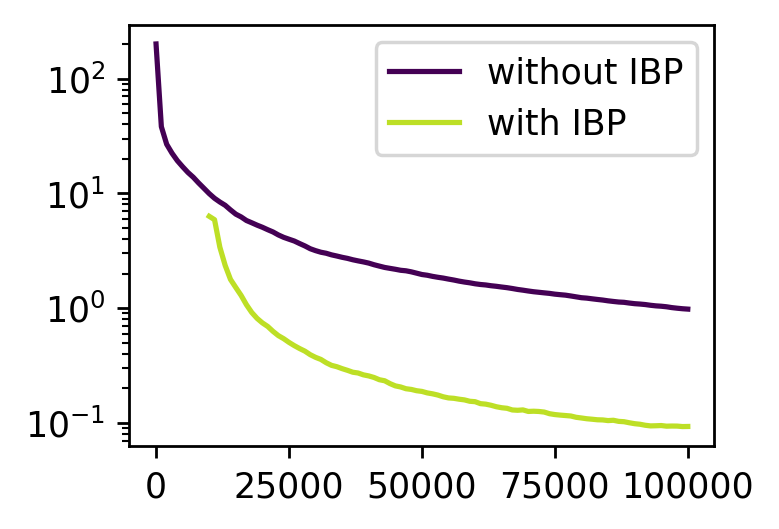

In [16]:
# devs from gt mean
pfs.initiate(figsize, dpi)
plt.yscale("log")
devs_no = alg.norm(means_no - c, axis=1)
plt.plot(schedule_no, devs_no)
devs_bi = alg.norm(means_bi - c, axis=1)
plt.plot(n_burn + schedule_bi, devs_bi)
plt.legend(snames, loc="upper right")
pfs.wrapup(path_prefix + "mean_devs.png")

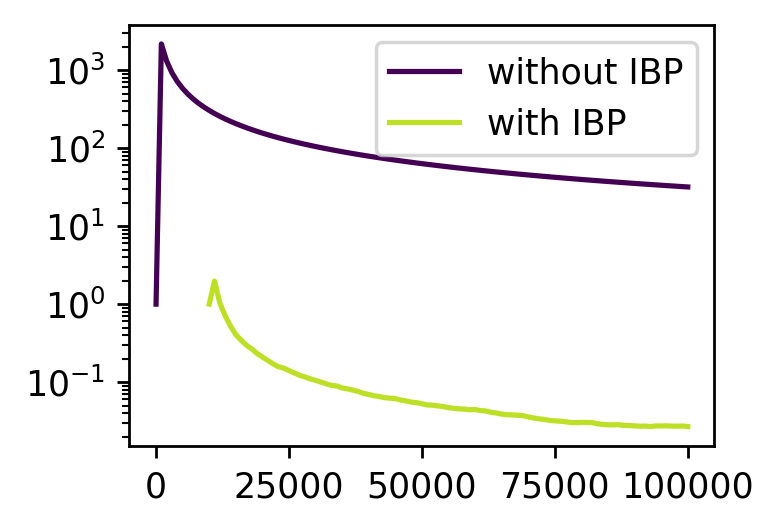

In [17]:
# devs from gt cov
pfs.initiate(figsize, dpi)
plt.yscale("log")
devs_no = np.abs(covs_no[:,0,0] - cov[0,0]) #alg.norm(covs_no - cov, axis=(1,2))
plt.plot(schedule_no, devs_no)
devs_bi = np.abs(covs_bi[:,0,0] - cov[0,0]) # alg.norm(covs_bi - cov, axis=(1,2))
plt.plot(n_burn + schedule_bi, devs_bi)
plt.legend(snames, loc="upper right")
pfs.wrapup(path_prefix + "cov_devs.png")

In [18]:
n_win = int(1e4)

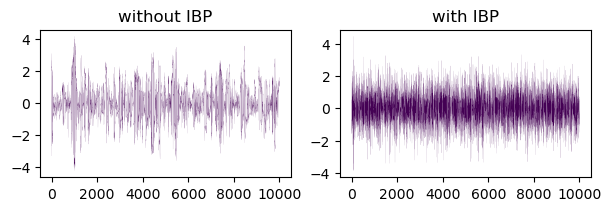

In [19]:
pfs.trace_plot_row([sams[-n_win:,0,1] for sams in samples], snames, lws=0.05)

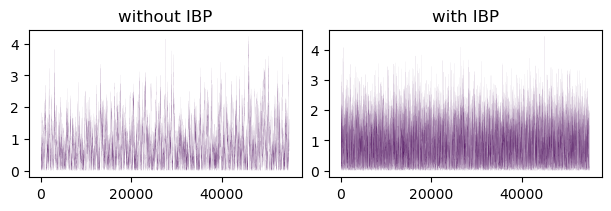

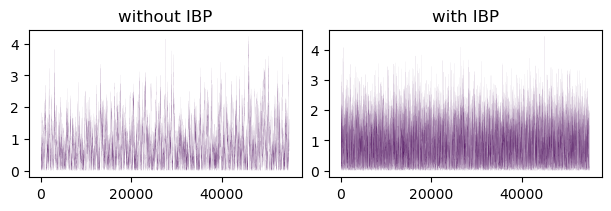

In [20]:
pfs.trace_plot_row([np.abs(sams[:,0,1]) for sams in samples], snames, lws=0.025)

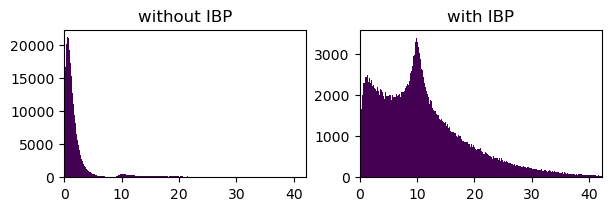

In [21]:
pfs.plot_step_hist_row(flat_steps, snames, same_range=True)

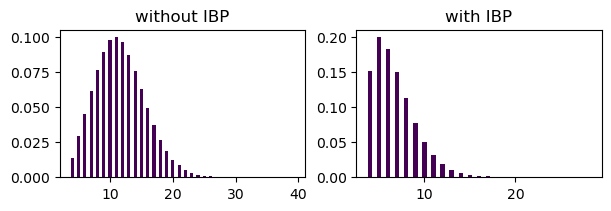

In [22]:
pfs.plot_tde_distr_row(tde, snames)

In [23]:
plt.rcParams["axes.prop_cycle"] = default_cycler

### Discussion
Although the distances in Euclidean/Frobenius norm of learned means/covs from the respective ground truth values diminish about equally fast for both methods, the properties of the particular problem (in particular its mean $(d,0,...,0)^T$ and initialization close to the origin) make it so that the method without init burn-in vastly overestimates the first coordinate variance throughout the sampling run, which ultimately inhibits its performance quite significantly (disturbingly enough, it is only an error in one out of 100 dimensions after all!).